# Analysis experiment 1: default values

The goal of the first experiment is to find sensible default values, based on performance data of random hyperparameter settings across different datasets.

In [1]:
import hyperimp.evaluate.default_params as hyperimp
import pandas as pd
from scipy.io import arff
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

In [2]:
# load data
svm_dict = {}
rf_dict = {}
for measure in ['acc', 'auc']:
    svm = pd.DataFrame(arff.loadarff('01 data/exp1/meta_svm_%s.arff' % measure)[0])
    #svm_jan = pd.DataFrame(arff.loadarff('01 data/exp1/meta_svm_jan.arff')[0])
    #svm = svm_jan
    svm['kernel'] = svm['kernel'].str.decode('utf-8')
    svm['shrinking'] = svm['shrinking'].str.decode('utf-8').map({'True' : True, 'False' : False})
    svm = svm[svm['kernel'] == 'rbf']
    svm_dict[measure] = svm
    
    rf = pd.DataFrame(arff.loadarff('01 data/exp1/meta_rf_%s.arff' %measure)[0])
    rf['bootstrap'] = rf['bootstrap'].str.decode("utf-8").map({'True' : True, 'False' : False})
    rf['criterion'] = rf['criterion'].str.decode("utf-8")
    rf_dict[measure] = rf
    

In [3]:
# algorithms to be evaluated
alg_names = ['rf', 'svm']
# hyperparameters to be evaluated
alg_params = {'svm': ['gamma','C','tol', 'shrinking'],
              'rf': ['bootstrap', 'criterion', 'max_features','min_samples_leaf','min_samples_split']}
# parameters defined on a log and integer scale
logs = ['gamma', 'C', 'tol']
integer = ['min_samples_leaf', 'min_samples_split']
boolnom = ['bootstrap', 'criterion', 'shrinking']

## Distribution of top _n_ per hyperparameter

The intuition behind our method of finding default values, is to find the hyperparameter value that most often resulted in good performance. To this end, we first take a subset of the top _n_ performance data points of each dataset. Note that this subset contains _n_ * nr. of datasets datapoints. To get an idea of the distribution of the hyperparameters within the top _n_ dat points, we visualize them in a histogram.

In [4]:
n = 10
m = 40

algs_dict = {}
dfs_dict = {}
for measure in ['acc', 'auc']:
    # initialze alg objects
    algs = hyperimp.init_algs('hyperimp/evaluate/parameters.csv', {'svm': svm_dict[measure], 'rf': rf_dict[measure]})
    algs_dict[measure] = algs
    
    # get top n data
    dfs = {}
    for alg in algs:
        dfs[alg.name] = hyperimp.get_topn(alg, n, m, False)
    dfs_dict[measure] = dfs

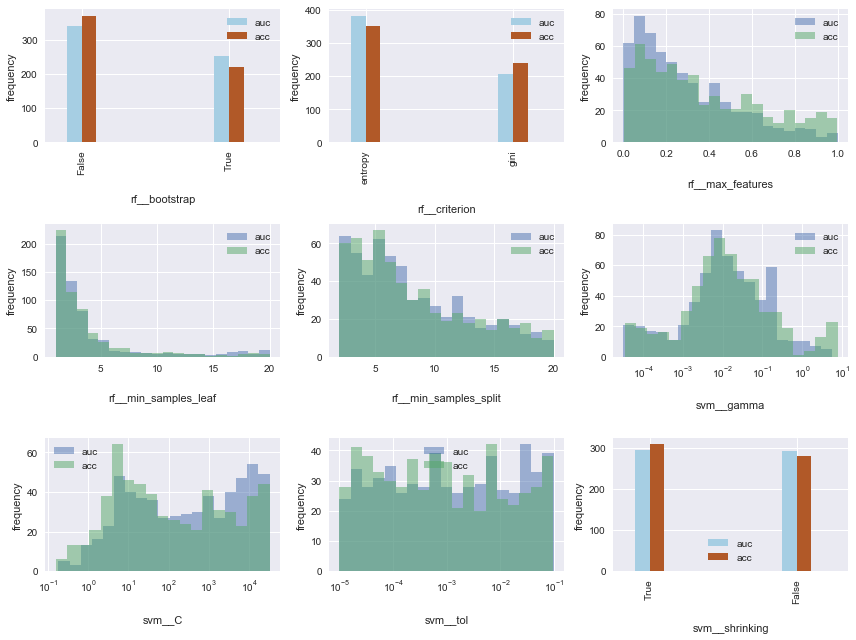

In [5]:
grid = True # put images on grid or not
cols = 3 # set nr columns in figure grid
ymax = None # set upper limit of plot; None for auto

if grid:
    nr_plots = sum([len(value) for key, value in alg_params.items()])
    rows = math.ceil(sum([len(value) for key, value in alg_params.items()])/cols)
    plt.figure(figsize = (4*cols,3*rows))
    index = 0

for alg in alg_names:
    for param in alg_params[alg]:
        if grid:
            index += 1
            plt.subplot(rows, cols, index)
        for measure, num, colormap in zip(['auc', 'acc'], [1, 0], ['Paired', 'Paired_r']):
            df = dfs_dict[measure][alg]
            if param in boolnom:
                df[param].value_counts().plot(kind='bar', alpha = 1, position = num, width = 0.10, label = measure, colormap = colormap)
                plt.legend()
            else:
                bins = 20
                log = param in logs
                intg = param in integer
                if log:
                    bins = np.logspace(np.log10(min(df[param])), np.log10(max(df[param])), 20)
                    plt.xscale('log', basex=10)
                if intg:
                    bins = int(max(df[param]) - min(df[param]) + 1)
                plt.hist(df[param], bins = bins, alpha = 0.5, label = measure)
                plt.legend()
        plt.xlabel('%s__%s' % (alg, param), labelpad=20)
        plt.ylim(0,ymax)
        plt.ylabel('frequency')
        plt.tight_layout()

        if not grid:
            plt.savefig('02 figures/histograms/hist__%s__%s.pdf' % (alg, param), format = 'pdf')
            plt.show()
if grid:
    plt.show()

## Meta-dependent features
For some hyperparameters, the default value in `sklearn` is dependent on the number of features $p$ in the datasets. The default of random forest's _max\_features_ is equal to $sqrt(p)$. The default of SVM's _gamma_ is equal to $1/p$.

In [6]:
from scipy.optimize import curve_fit
def func1(x, a):
    return a * x
def func2(x, a):
    return x ** a
def func3(x, a):
    return a**np.sqrt(x)
def func4(x, a):
    return 1/x
def func5(x, a):
    return 0.006
def func6(x,a):
    return x ** 0.25

def evaluate(x, y, popt):
    residuals = y - func(x, popt)
    ss_res = np.sum(residuals**2)
    rmse = np.sqrt(ss_res/len(x))
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res/ss_tot)
    return rmse, r_squared

def evaluate_log(x, y, popt):
    residuals = np.log(y + 1) - np.log(func(x, popt) + 1)
    ss_res = np.sum(residuals**2)
    rmsle = np.sqrt(ss_res/len(x))
    ss_tot = np.sum((np.log(y + 1) - np.mean(np.log(y + 1)))**2)
    r_squared_log = 1 - (ss_res/ss_tot)
    return rmsle, r_squared_log

### RandomForestClassifier's max\_features

Datasets with < 2000 features (59 datasets)
	 m = 0.16*n,	 	 RMSE: 21.64, 	 R2: 0.77, 	 RSMLE: 0.90, 	 LR2: 0.13
	 m = n^0.74,	 	 RMSE: 23.13, 	 R2: 0.73, 	 RSMLE: 0.73, 	 LR2: 0.42
	 m = 1.15^sqrt(n),	 RMSE: 24.33, 	 R2: 0.70, 	 RSMLE: 1.24, 	 LR2: -0.66
	 m = n^0.25,	 	 RMSE: 47.16, 	 R2: -0.11, 	 RSMLE: 1.39, 	 LR2: -1.10


/Users/hildeweerts/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


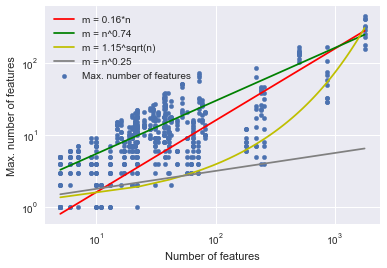

Datasets with < 150 features (52 datasets)
	 m = 0.31*n,	 	 RMSE: 8.96, 	 R2: 0.12, 	 RSMLE: 0.66, 	 LR2: 0.21
	 m = n^0.70,	 	 RMSE: 8.48, 	 R2: 0.21, 	 RSMLE: 0.62, 	 LR2: 0.31
	 m = 1.43^sqrt(n),	 RMSE: 9.36, 	 R2: 0.04, 	 RSMLE: 0.69, 	 LR2: 0.14
	 m = n^0.25,	 	 RMSE: 12.51, 	 R2: -0.72, 	 RSMLE: 1.22, 	 LR2: -1.69


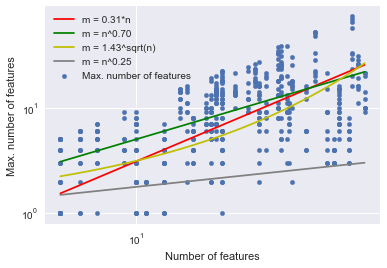

In [7]:
rf_topn = dfs_dict['acc']['rf']
rf_topn['max_features_int'] = np.ceil(rf_topn['max_features'] * rf_topn['NumberOfFeatures'])

for filter_val in [2000, 150]:
    rf_topn_f = rf_topn[rf_topn['NumberOfFeatures'] < filter_val]
    print("Datasets with < %s features (%s datasets)" % (filter_val, len(rf_topn_f['task_id'].unique())))
    x = rf_topn_f['NumberOfFeatures']
    y = rf_topn_f['max_features_int']
    plt.scatter(x,y,s = 20,label = "Max. number of features")
    for func in [func1, func2, func3, func6]:
        popt, pcov = curve_fit(func, x, y)
        rmse, r_squared = evaluate(x, y, popt)
        rmsle, r_squared_log = evaluate_log(x, y, popt)
        x_plot = np.linspace(int(min(x)), int(max(x)), 100)
        if func == func1:
            print('\t m = %.2f*n,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (popt[0], rmse, r_squared, rmsle, r_squared_log))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = %.2f*n' %popt[0], c='r')
        elif func == func2:
            print('\t m = n^%.2f,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (popt[0], rmse, r_squared, rmsle, r_squared_log))
            #print('\t \t RMSE: %.2f, \t R2: %.2f'% (popt[0], rmse, r_squared))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = n^%.2f' %popt[0], c='g')
        elif func == func3:
            print('\t m = %.2f^sqrt(n),\t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (popt[0], rmse, r_squared, rmsle, r_squared_log))
            #print(',\t RMSE: %.2f, \t R2: %.2f'% (popt[0], rmse, r_squared))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = %.2f^sqrt(n)' %popt[0], c='y')
        elif func == func6:
            print('\t m = n^0.25,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (rmse, r_squared, rmsle, r_squared_log))
            #print('\t \t RMSE: %.2f, \t R2: %.2f'% (popt[0], rmse, r_squared))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = n^0.25' %popt[0], c='grey')
            
    plt.xlabel('Number of features')
    plt.ylabel('Max. number of features')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('scatter_max_features.eps', format = 'eps')
    plt.show()
    


### SVM's gamma

Datasets with < 2000 features (59 datasets)
	 m = 0.00009*n,	 	 RMSE: 1.19, 	 R2: -0.08, 	 RSMLE: 0.44, 	 LR2: -0.13
	 m = 1/n,	 	 RMSE: 1.17, 	 R2: -0.04, 	 RSMLE: 0.42, 	 LR2: -0.02
	 m = 0.006,	 	 RMSE: 1.19, 	 R2: -0.08, 	 RSMLE: 0.44, 	 LR2: -0.12


/Users/hildeweerts/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


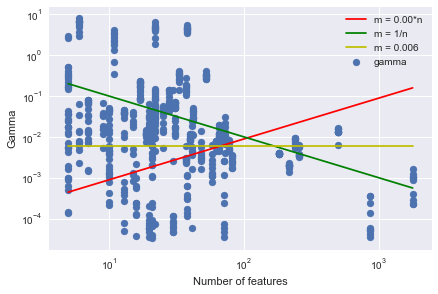

Datasets with < 150 features (52 datasets)
	 m = 0.00574*n,	 	 RMSE: 1.25, 	 R2: -0.07, 	 RSMLE: 0.46, 	 LR2: -0.12
	 m = 1/n,	 	 RMSE: 1.24, 	 R2: -0.05, 	 RSMLE: 0.44, 	 LR2: -0.04
	 m = 0.006,	 	 RMSE: 1.27, 	 R2: -0.09, 	 RSMLE: 0.46, 	 LR2: -0.14


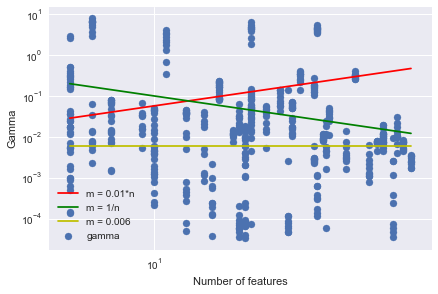

In [8]:
svm_topn = dfs_dict['acc']['svm']

for filter_val in [2000, 150]:
    svm_topn_f = svm_topn[svm_topn['NumberOfFeatures'] < filter_val]
    
    print("Datasets with < %s features (%s datasets)" % (filter_val, len(svm_topn_f['task_id'].unique())))
    x = svm_topn_f['NumberOfFeatures']
    y = svm_topn_f['gamma']
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(x,y)
    plt.tight_layout()
    for func in [func1, func4, func5]:
        popt, pcov = curve_fit(func, x, y)
        rmse, r_squared = evaluate(x, y, popt)
        rmsle, r_squared_log = evaluate_log(x, y, popt)
        x_plot = np.linspace(int(min(x)), int(max(x)), 100)
        if func == func1:
            print('\t m = %.5f*n,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (popt[0], rmse, r_squared, rmsle, r_squared_log))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = %.2f*n' %popt[0], c='r')
        elif func == func4:
            print('\t m = 1/n,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (rmse, r_squared, rmsle, r_squared_log))
            plt.plot(x_plot, func(x_plot, popt[0]), label = 'm = 1/n', c='g')
        elif func == func5:
            print('\t m = 0.006,\t \t RMSE: %.2f, \t R2: %.2f, \t RSMLE: %.2f, \t LR2: %.2f'% 
                  (rmse, r_squared, rmsle, r_squared_log))
            plt.plot(x_plot, len(x_plot)*[0.006], label = 'm = 0.006', c='y')
    
    plt.xlabel('Number of features')
    plt.ylabel('Gamma')
    plt.legend()
    plt.show()

## Default parameters

In [9]:
n = 10
m = 800

def_params_dict = {} # dictionary containing all default parameters for all algorithms
# requires parameters.csv (hyperimp/evaluate) and data in algs to be configured correctly!
measure = 'acc'

for alg in algs_dict[measure]:
    df = hyperimp.get_topn(alg, n, m, False)
    def_params = hyperimp.find_default(alg, df, False)
    def_params_df = pd.DataFrame(def_params).transpose()
    print('Average default value %s:' %alg.name)
    display(def_params_df.mean())
    print('Standard deviation default value %s:' %alg.name)
    display(def_params_df.std())
    #display(def_params_df)
    if alg.name == 'rf':
        name = 'random_forest'
    elif alg.name == 'svm':
        name = 'svm'
    def_params_dict[name] = def_params
    
# save default parameter dictionary to pickle
with open('experiment_2/hyperimp/experiment/def_params.pickle', 'wb') as handle:
    pickle.dump(def_params_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Average default value rf:


bootstrap            0.000000
max_features         0.737347
min_samples_leaf     1.000000
min_samples_split    5.000000
dtype: float64

Standard deviation default value rf:


bootstrap            0.000000
max_features         0.009045
min_samples_leaf     0.000000
min_samples_split    0.000000
dtype: float64

Average default value svm:


C            8.888757
gamma        0.011584
shrinking    0.016949
tol          0.000046
dtype: float64

Standard deviation default value svm:


C            3.223905e+00
gamma        1.518758e-04
shrinking    0.000000e+00
tol          8.828857e-08
dtype: float64

In [10]:
for alg in algs:
    topn = hyperimp.get_topn(alg, n, m, False)
    def_params = hyperimp.find_default(alg, topn, True)
    for key, value in hyperimp.default_score(alg, topn, def_params).items():
        print('%s \t %s : %f' %(alg.name, key, value))

rf 	 max_features : 0.000000
rf 	 min_samples_leaf : 0.362712
rf 	 min_samples_split : 0.077966
rf 	 criterion : 0.649153
rf 	 bootstrap : 0.574576
svm 	 gamma : 0.144068
svm 	 C : 0.191525
svm 	 tol : 0.091525
svm 	 shrinking : 0.433898
